# **Prepare Synthetic Data**

In this notebook, we focus on **preparing the synthetic dataset** for fine-tuning and evaluation. This involves splitting the data into training, validation, and test sets, and ensuring the data is in the correct format for downstream tasks.

### Objectives:
- **Data Splitting:** Divide the synthetic data into training, validation, and test sets.
- **Data Analysis:** Validate the distribution of grounded vs. not grounded samples in each split.
- **Data Formatting:** Prepare the data in the required format for fine-tuning and evaluation.

### Key Steps:
1. **Read Data:** Load the synthetic data from the JSON Lines file.
2. **Create Splits:** Split the data into training, validation, and test sets.
3. **Validate Splits:** Ensure the splits have a balanced distribution of grounded vs. not grounded samples.
4. **Prepare Fine-Tuning Format:** Convert the data into the format required for fine-tuning.
5. **Save Data:** Save the training and validation data in JSON Lines format and the test data in CSV format.

This notebook ensures that the synthetic data is well-prepared and formatted for effective fine-tuning and evaluation.

**Imports**

In [1]:
import json
import os
import datetime

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context("talk")  # Increase font sizes

from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from openai import AzureOpenAI

from utils.sdg_generator_helper import get_instruction

import dotenv
dotenv.load_dotenv(".env")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\povelf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Read data**

In [2]:
path='data/ft-judge/single/chunk-specific-synthetic-questions.jsonl'
with open(path, 'r') as f:
    data = [json.loads(line) for line in f if line.strip()]

In [3]:
# Flatten the data using json_normalize
df = pd.json_normalize(data)
df = df.drop(columns=['question_number'])

df.head(1)

,synthetic_question,explanation,synthetic_response,chunk_id,is_grounded,chunk_data,aggregated_context,domain,difficulty,tone,language,question_length,synthetic_embedding
0,What is the price of the SummitClimber Backpac...,The provided chunk contains detailed informati...,The SummitClimber Backpack purchased by David ...,252167c94bb6_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,True,## Customer_Info\n\nFirst Name: David \nLast N...,single chunk was used,Usage instructions,Beginner,Neutral,English,14,"[-0.009115601889789104, 0.02129325643181801, -..."


**Create splits**

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets:
#   - Training set: 78% of the data
#   - Validation set: 10% of the data
#   - Testing set: 10% of the data

train, temp = train_test_split(df, test_size=0.20, random_state=23)
val, test = train_test_split(temp, test_size=0.5, random_state=23)
print(len(train), len(val), len(test))

24 3 3


**validating grounded vs not grounded ratio for each dataset**

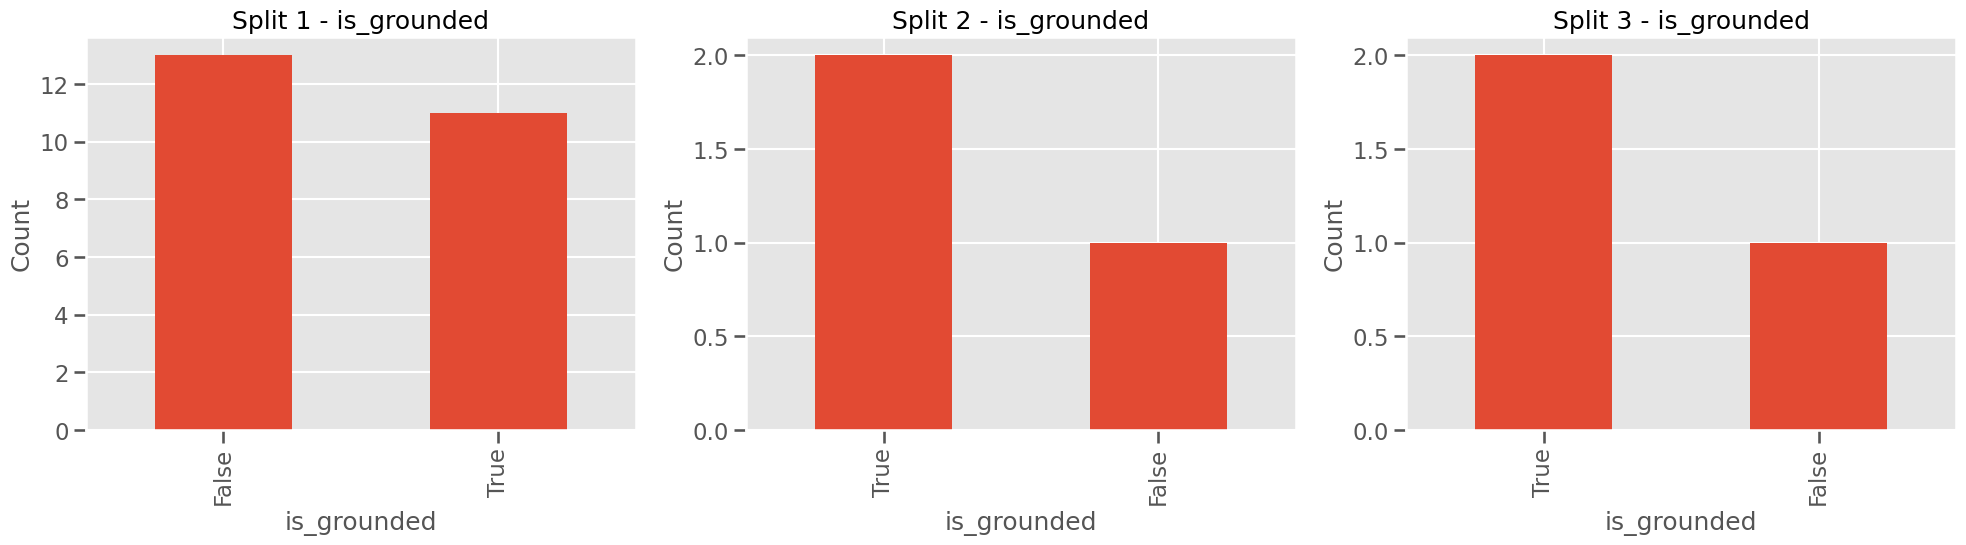

In [5]:
splits = [train, val, test]

# Plot the distributions for each split
plt.figure(figsize=(20, 10))

# Plot Category counts for each split
for i, df_split in enumerate(splits):
    plt.subplot(2, 3, i + 1)
    category_counts_split = df_split['is_grounded'].value_counts()
    category_counts_split.plot(kind='bar')
    plt.xlabel('is_grounded')
    plt.ylabel('Count')
    plt.title(f'Split {i + 1} - is_grounded')

# Show the plots
plt.tight_layout()
plt.show()

**Prepare fine-tuning format and write to file**

In [ ]:
import json
import pandas as pd

def store_fine_tuning_data_from_df(df: pd.DataFrame, file_path: str):
    json_objects = []
    
    for _, row in df.iterrows():
        # Construct the user message with the synthetic question and provided chunk data.
        user_message = (
            f"QUESTION: {row['synthetic_question']}\n"
            f"CHUNK: {row['chunk_data']}\n"
            f"RESPONSE: {row['synthetic_response']}"
        )
        
        # Construct the assistant message as a JSON object.
        assistant_response = {
            "label": row["is_grounded"],
            "explanation": row["explanation"]
        }
        assistant_message = json.dumps(assistant_response, ensure_ascii=False)
        
        json_objects.append({
            "messages": [
                {"role": "system", "content": get_instruction("configs/prompts/judge/system_message_single_groundedness.txt")},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": assistant_message}
            ]
        })

    # Ensure the directory exists before writing the file.
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Write the list of JSON objects to a JSON Lines file.
    with open(file_path, 'w', encoding='utf8') as file:
        for obj in json_objects:
            file.write(json.dumps(obj, ensure_ascii=False) + '\n')
    
    return json_objects


**saving train and val to jsonl, test to csv**

In [7]:
train_path = 'data/ft-judge/single/train.jsonl'
val_path = 'data/ft-judge/single/val.jsonl'
test_path_csv = 'data/ft-judge/single/test.csv'

In [8]:
json_train = store_fine_tuning_data_from_df(train, train_path)
json_val = store_fine_tuning_data_from_df(val, val_path)
test.to_csv(test_path_csv, index=False)  # Saves without the index column